In [210]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [211]:
%matplotlib inline

In [342]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [343]:
# The file does the following:
    # fill in make
    # fill in age and remaining_coe in months
    # fill in mileage based on age
    # fill in power and engine cap
    # fill in arf
    # One-hot encoding for categorical attributes

In [344]:
df = pd.read_csv('./train.csv')

In [345]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16784 entries, 0 to 16783
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   listing_id         16784 non-null  int64  
 1   title              16784 non-null  object 
 2   make               14624 non-null  object 
 3   model              16784 non-null  object 
 4   description        16439 non-null  object 
 5   manufactured       16590 non-null  float64
 6   original_reg_date  318 non-null    object 
 7   reg_date           16583 non-null  object 
 8   type_of_vehicle    16784 non-null  object 
 9   category           16784 non-null  object 
 10  transmission       16784 non-null  object 
 11  curb_weight        16205 non-null  float64
 12  power              14447 non-null  float64
 13  fuel_type          3490 non-null   object 
 14  engine_cap         16731 non-null  float64
 15  no_of_owners       16608 non-null  float64
 16  depreciation       163

In [ ]:
# fill in make according to model

In [325]:
#fill in make
dfvalid = df.dropna(subset = ['make'])

missingMake = df.make.isnull()
dfm = df[missingMake]
missingModelAge = []
for idx, row in dfm.iterrows():
    model = row['model']
    missingModelAge.append(model)

mapper = {}
for idx, row in dfvalid.iterrows():
    model = row['model']
    make = row['make']
    mapper[model] = make

for idx, row in dfm.iterrows():
    model = row['model']
    if len(mapper[model]):
        df.at[idx, 'make'] = mapper[model]

print(df['make'].isnull().sum())

0


In [ ]:
# fill in age and remaining_coe in months
# the dataset collection time is 2021.9

In [346]:
# get age and remaining coe
def month(x):
    if pd.isna(x):
        return np.nan
    mapper = {}
    all_m = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    for i in range(12):
        mapper[all_m[i]] = i + 1
    if len(str(x)) < 11:
        return (2021 - int(x)) * 12
    s = x.split('-')
    year = int(s[-1])
    month = mapper[s[-2]]
    if year == 2021:
        age_in_month = 9 - month
    else:
        age_in_month = (2021 - year) * 12 - 3
    return age_in_month


d1 = df['manufactured'].isnull()
df['age'] = df['manufactured']
df.loc[d1, 'age'] = df.loc[d1, 'manufactured']
d1 = df['age'].isnull()
df.loc[d1, 'age'] = df.loc[d1, 'original_reg_date']
d1 = df['age'].isnull()
df.loc[d1, 'age'] = df.loc[d1, 'reg_date']
df['age'] = df['age'].map(month)

def filterNeg(x):
    if x < 0:
        return 0
    return x


d1 = df['reg_date'].isnull()
df['remaining_coe'] = df['reg_date'].copy()
df.loc[d1, 'remaining_coe'] = df.loc[d1, 'reg_date']
df['remaining_coe'] = 120 - df['remaining_coe'].map(month)
df['remaining_coe'] = df['remaining_coe'].map(filterNeg)

In [347]:
for idx, row in df.iterrows():
    title = row['title']
    if '(COE' in title:
        month = int(title[-8:-6])
        year = int(title[-5:-1])
        remain = 2021 * 12 + 9 - (year * 12 + month)
        df.at[idx, 'remaining_coe'] = remain
    elif '(New 5-yr COE)' in title:
        df.at[idx, 'remaining_coe'] -= 5 * 12

In [ ]:
# remove outliers

In [349]:
df.loc[df.age < 0, 'age'] = 0
df.loc[df.age > 20000, 'age'] = 0

In [350]:
# fill in mileage
df_valid = df.dropna(subset = ['mileage', 'age'])
no_of_owners = df_valid['age'].to_numpy()
caps = df_valid['mileage'].to_numpy()

k = 100
for idx, row in df.iterrows():
    if idx % 10000 == 0:
        print(idx)

    p, e = row['age'], row['mileage']
    
    if type(row["mileage"]) == float and pd.isna(row["mileage"]):

        diff = np.abs(no_of_owners - p)

        indices = np.argsort(diff)[:k]

        k_caps = caps[indices]

        avg = np.average(k_caps)

        # Set the weight value of the current row to the median
        df.at[idx, 'mileage'] = avg
print(df['mileage'].isnull().sum())

0
10000
0


In [ ]:
# fill in power and engine_cap

In [351]:
# fill in power according to model
from collections import defaultdict
df_valid = df.dropna(subset = ['power'])
ps = df_valid['power'].to_numpy()

missingPs = df.power.isnull()
dfm = df[missingPs]
missingPower = []
for idx, row in dfm.iterrows():
    model = row['model']
    missingPower.append(model)

mapper = defaultdict(list)
for idx, row in df_valid.iterrows():
    model = row['model']
    power = row['power']
    mapper[model].append(power)

for idx, row in dfm.iterrows():
    model = row['model']
    if len(mapper[model]):
        df.at[idx, 'power'] = np.average(mapper[model])

print(df['power'].isnull().sum())

1582


In [331]:

# df.at[8199, 'engine_cap'] = np.nan

In [352]:
# fill in engine_cap according to model
df_valid = df.dropna(subset = ['engine_cap'])
ps = df_valid['engine_cap'].to_numpy()

missingPs = df.power.isnull()
dfm = df[missingPs]
missingPower = []
for idx, row in dfm.iterrows():
    model = row['model']
    missingPower.append(model)

mapper = defaultdict(list)
for idx, row in df_valid.iterrows():
    model = row['model']
    power = row['engine_cap']
    mapper[model].append(power)

for idx, row in dfm.iterrows():
    model = row['model']
    if len(mapper[model]):
        df.at[idx, 'engine_cap'] = np.average(mapper[model])

print(df['engine_cap'].isnull().sum())

53


In [353]:
# fill in power according to engine_cap
df_valid = df.dropna(subset = ['power', 'engine_cap'])
powers = df_valid['power'].to_numpy()
caps = df_valid['engine_cap'].to_numpy()

k = 100

# Loop over each data point in our dataset
for idx, row in df.iterrows():
    p, e = row['power'], row['engine_cap']
    
    if type(row["power"]) == float and pd.isna(row["power"]):
        diff = np.abs(caps - e)

        indices = np.argsort(diff)[:k]

        k_powers = powers[indices]

        avg = np.average(k_powers)

        # Set the weight value of the current row to the median
        df.at[idx, 'power'] = avg

In [354]:
# fill in engine_cap according to power
df_valid = df.dropna(subset = ['power', 'engine_cap'])
powers = df_valid['power'].to_numpy()
caps = df_valid['engine_cap'].to_numpy()

k = 100
for idx, row in df.iterrows():
    if idx % 10000 == 0:
        print(idx)

    p, e = row['power'], row['engine_cap']
    
    if type(row["engine_cap"]) == float and pd.isna(row["engine_cap"]):

        diff = np.abs(powers - p)

        indices = np.argsort(diff)[:k]

        k_caps = caps[indices]

        avg = np.average(k_caps)

        # Set the weight value of the current row to the median
        df.at[idx, 'engine_cap'] = avg

0
10000


In [ ]:
# append relevant categorical attributes

In [355]:
cars_dummies = pd.get_dummies(df['fuel_type'])
df = pd.concat([df, cars_dummies], axis=1)
cars_dummies = pd.get_dummies(df['type_of_vehicle'])
df = pd.concat([df, cars_dummies], axis=1)

In [ ]:
# fill in arf according to omv using domain knowledge

In [356]:
fill_arf = df[df.arf.isnull()]
for idx, row in fill_arf.iterrows():
    omv = row['omv']
    if omv < 20000:
        df.at[idx, 'arf'] = omv
    elif omv >= 20000 and omv <= 50000:
        df.at[idx, 'arf'] = (omv - 20000) * 1.40 + 20000
    else:
        df.at[idx, 'arf'] =  (omv - 50000) * 1.80 + 62000
print(len(df[df.arf.isnull()]))

41


In [ ]:
# fill in coe according to domain knowledge

In [357]:
coe_to_search = []
to_search = df[df.coe.isnull()]

for idx, row in to_search.iterrows():
    # category -> A / B
    power = row["power"]
    engine_cap = row["engine_cap"]
    cat = 2
    month = row["remaining_coe"]
    if engine_cap <= 1600 and power <= 97:
        cat = 1
    coe_to_search.append((cat, month))

coe_to_search = list(set(coe_to_search))
print(len(coe_to_search))

In [358]:
t_to_coe = {}

for t in coe_to_search:
    t_to_coe[str(t)] = []

remains = df[~df.coe.isnull()]

for idx, row in remains.iterrows():
    if idx % 10000 == 0:
        print(idx)

    power = row["power"]
    engine_cap = row["engine_cap"]
    cat = 2
    month = row["remaining_coe"]
    if engine_cap <= 1600 and power <= 97:
        cat = 1
    
    t = (cat, month)
    
    coe = row["coe"]
    if t in coe_to_search:
        t_to_coe[str(t)].append(coe)
        
c = 0
for idx, row in df.iterrows():
    power = row["power"]
    engine_cap = row["engine_cap"]
    cat = 2
    month = row["remaining_coe"]
    if engine_cap <= 1600 and power <= 97:
        cat = 1
    t = str((cat, month))

    if type(row["coe"]) == float and pd.isna(row["coe"]):
        if t in t_to_coe:
            l = t_to_coe[t]
            if len(l) > 0:
                avg = sum(l) / len(l)
                df.at[idx, 'coe'] = avg
                c += 1
print(c)

In [ ]:
# done with basic cleaning

In [360]:
df.info()
df.to_csv('train_basic.csv')
# train_basic:
# filled make, mileage, age, remaining_coe, power and engine cap, coe, arf with partial one-hot encoding for categorical attributes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16784 entries, 0 to 16783
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   listing_id         16784 non-null  int64  
 1   title              16784 non-null  object 
 2   make               14624 non-null  object 
 3   model              16784 non-null  object 
 4   description        16439 non-null  object 
 5   manufactured       16590 non-null  float64
 6   original_reg_date  318 non-null    object 
 7   reg_date           16583 non-null  object 
 8   type_of_vehicle    16784 non-null  object 
 9   category           16784 non-null  object 
 10  transmission       16784 non-null  object 
 11  curb_weight        16205 non-null  float64
 12  power              16784 non-null  float64
 13  fuel_type          3490 non-null   object 
 14  engine_cap         16784 non-null  float64
 15  no_of_owners       16608 non-null  float64
 16  depreciation       163

In [ ]:
# The code below summarizes some methods we tried but gave up on eventually

In [380]:
# caclulate dereg_value based on domain knowledge
for idx in range(len(df)):
    row = df.iloc[idx]
    if pd.isnull(row["dereg_value"]):

        max_age = 10 * 12
        age = row["age"]
        time_left = max_age - age
        coe = row["coe"]
        omv = row["omv"]
        arf = row["arf"]
        parf_ratio = 0
        if age <  5 * 12:
            parf_ratio = 0.75
        elif age >= 5 * 12 and age < 10 * 12:
            parf_ratio = 0.75 - math.ceil((age - 5 * 12) / 12) * 0.05 
        remaining_coe = row['remaining_coe']

        coe_rebate = coe * remaining_coe / 120
        dereg_value = parf_ratio * arf + coe_rebate
        if dereg_value <= 0:
            dereg_value = np.nan

        df.iat[idx, 20] = dereg_value

print(df.dereg_value.isnull().sum())

1104


In [50]:
# trying to confirm remaining_coe values based on domain knowledge
# check whether the domain knowledge is valid beforehand
df['new_price'] = df['price']

for idx in range(len(df)):
    row = df.iloc[idx]
    depreciation = row['depreciation']
    age = row["age"]
    coe = row["coe"]
    omv = row["omv"]
    arf = row["arf"]
    remaining_coe = row['remaining_coe']

    min_parf = min(0.55 * omv, arf)
    if age <= 96:
        min_parf = 0.5 * arf ####
    elif age > 96 and age <= (2021 - 2008) * 12:
        min_parf = 0.5 * min(omv, arf)
    new_price = depreciation * ((remaining_coe - 6) / 12) + min_parf
    df.iloc[idx, 32] = new_price

SyntaxError: invalid syntax (<ipython-input-50-68960a74e976>, line 18)

In [53]:
diff = (df['new_price'] - df['price'])

-21438.977624076717
287047.5
-1699869.0
99.48814306077492


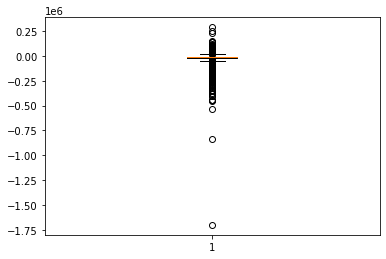

In [54]:
plt.boxplot(diff)
plt.show()
# not very ideal